### HW 4: Sequence Models
For this assignment, I will be using the Germany electricity power for 2006-2017 dataset from kaggle, located at https://www.kaggle.com/datasets/mvianna10/germany-electricity-power-for-20062017. This dataset introduces the problem of trying to predict the electricity power in Germany given a previous set of times. This problem requires a sequence model because the data is a time series and a normal neural network using a feed forwards network does not account for the order of data. To implement the models, I will be using PyTorch's RNN, GRU, and LSTM frameworks.

In [30]:
#import the necessary packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as du
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics.pairwise import cosine_similarity

#### Conduct Exploratory Data Analysis

In [2]:
#read in the data
eng_data = pd.read_csv("../../PIML/HW4/opsd_germany_daily.csv")
eng_data.head(5)

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.184,NaN,NaN,NaN
1,2006-01-02,1380.521,NaN,NaN,NaN
2,2006-01-03,1442.533,NaN,NaN,NaN
3,2006-01-04,1457.217,NaN,NaN,NaN
4,2006-01-05,1477.131,NaN,NaN,NaN


In [3]:
eng_data.tail(5)

,Date,Consumption,Wind,Solar,Wind+Solar
4378,2017-12-27,1263.94091,394.507,16.530,411.037
4379,2017-12-28,1299.86398,506.424,14.162,520.586
4380,2017-12-29,1295.08753,584.277,29.854,614.131
4381,2017-12-30,1215.44897,721.247,7.467,728.714
4382,2017-12-31,1107.11488,721.176,19.980,741.156


In [4]:
eng_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4383 entries, 0 to 4382
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         4383 non-null   object 
 1   Consumption  4383 non-null   float64
 2   Wind         2920 non-null   float64
 3   Solar        2188 non-null   float64
 4   Wind+Solar   2187 non-null   float64
dtypes: float64(4), object(1)
memory usage: 171.3+ KB


In [5]:
#check for null data
eng_data.isnull().sum()

Date              0
Consumption       0
Wind           1463
Solar          2195
Wind+Solar     2196
dtype: int64

In [6]:
#Since more than half of the entries in Wind, Solar, and Wind+Solar are Nan, disregard the columns.
eng_data.drop("Wind", axis = 1, inplace = True)
eng_data.drop("Solar", axis = 1, inplace = True)
eng_data.drop("Wind+Solar", axis = 1, inplace = True)
eng_data.head(5)

,Date,Consumption
0,2006-01-01,1069.184
1,2006-01-02,1380.521
2,2006-01-03,1442.533
3,2006-01-04,1457.217
4,2006-01-05,1477.131


In [7]:
#Since the data is sequential, the date is irrevelant and can be dropped.
eng_data.drop("Date", axis = 1, inplace = True)
eng_data.head(5)

,Consumption
0,1069.184
1,1380.521
2,1442.533
3,1457.217
4,1477.131


In [8]:
#Normalize the dataset
def normalize(x):
    """
    Normalizes the data within dataframe x
    """
    x_norm = (x-x.min())/(x.max()-x.min())
    return x_norm

eng_data = normalize(eng_data)
eng_data.head(5)

,Consumption
0,0.261527
1,0.620552
2,0.692063
3,0.708996
4,0.731960


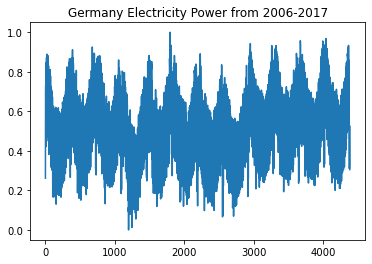

In [9]:
#Plot the data
eng_data = eng_data.to_numpy()
x = np.arange(1, eng_data.shape[0]+1)
plt.title("Germany Electricity Power from 2006-2017")
plt.plot(x, eng_data)

Define the Dataloader

In [10]:
class EngData(du.Dataset):
    """
    Represents the electricity power data and
    handles the passing of data in batches.
    """
    def __init__(self, eng_data, win_size):
        self.data = eng_data
        self.win_size = win_size
        
    def __len__(self):
        return len(self.data) - self.win_size
        
    def __getitem__(self, idx):
        entries = torch.tensor(self.data[idx:idx+self.win_size])
        labels = torch.tensor(self.data[idx+self.win_size])
        
        return entries, labels

Define the model

In [11]:
class Model(nn.Module):
    """
    Represents either a RNN, LSTM, or GRU depending
    on the given classification cls.
    """
    
    def __init__(self, c_type, in_dim, hidden_dim, out_dim, num_layers, win_size):
        super(Model, self).__init__()
        if c_type == "RNN":
            self.r = nn.RNN(in_dim, hidden_dim, batch_first = True, num_layers = num_layers)
        elif c_type == "GRU":
            self.r = nn.GRU(in_dim, hidden_dim, batch_first = True, num_layers = num_layers)
        else:
            self.r = nn.LSTM(in_dim, hidden_dim, batch_first = True, num_layers = num_layers)
            
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(win_size* hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)
            
    def forward(self, x):
        #feed the input through the network
        x, hn = self.r(x)
        
        x = self.flatten(x)
        
        #feed the output through an MLP
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x

Do a train, test, and validation split on the data.

In [12]:
#do a train/test/validation split of 75% 15% 10%
train_data, other = train_test_split(eng_data, test_size = 0.25)
valid_data, test_data = train_test_split(other, test_size = 0.4)

In [13]:
#define training parameters
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"using {device}")

batch_size = 10
learning_rate = 0.01
epochs = 5
in_dim = eng_data.shape[1]
hidden_dim = 4
out_dim = 1
num_layers = 4

using cpu


Initialize the Dataloaders

In [14]:
#initialize datasets
train_data = EngData(train_data, batch_size)
valid_data = EngData(valid_data, batch_size)
test_data = EngData(test_data, batch_size)

#set up the dataloader
train_loader = du.DataLoader(dataset=train_data,
                             batch_size=batch_size,
                             shuffle=True)
valid_loader = du.DataLoader(dataset=valid_data,
                             batch_size=batch_size,
                             shuffle=True)
test_loader = du.DataLoader(dataset=test_data,
                             batch_size=batch_size,
                             shuffle=True)

### Task 1 Part 1: RNN

For the RNN part, I will be using PyTorch's RNN framework. The RNN will accept input that is the dimension of the time series data, which in our case has 1 feature. The hidden dim will be 2, and it will accept the data batch first as that is how our data is passed from the dataloader. The RNN will have 4 layers. The input will be b x 1 the output of the RNN will be fed into a multi layer perceptron and transformed into b x out_dim, which also happens to be 1. In between layers, relu activation will be applied. To evaluate my model, I will be using mean squared error loss where I will aim to minimize the mse loss produced by the network.

In [15]:
#Initialize the Model
RNN_model = Model("RNN", in_dim, hidden_dim, out_dim, num_layers, batch_size)
optimizer = optim.Adam(RNN_model.parameters(), lr=learning_rate)

#send the model to the device
RNN_model = RNN_model.to(device)
RNN_model.train()

Model(
  (r): RNN(1, 4, num_layers=4, batch_first=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=40, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=1, bias=True)
)

Train the model

In [16]:
test_losses = []
epx = []
for epoch in range(1, epochs+1):
    sum_loss = 0.
    RNN_model.train()
    for batch_idx, (contexts, targets) in enumerate(train_loader):
        
        optimizer.zero_grad()
        
        #send information to device
        contexts, targets = contexts.to(device), targets.to(device)
        
        #run the forward pass
        preds = RNN_model(contexts.float())
        
        #compute loss
        loss = F.mse_loss(preds, targets.float())
        sum_loss += loss.item()
        
        #backpropagate
        loss.backward()
        optimizer.step()
    
    sum_loss /= len(train_loader)
    RNN_model.eval()
    
    with torch.no_grad():
        valid_loss = 0.
        for batch_idx, (contexts, targets) in enumerate(valid_loader):
            
            #send information to device
            contexts, targets = contexts.to(device), targets.to(device)
            
            #run the forward pass
            preds = RNN_model(contexts.float())
            
            #compute loss
            loss = F.mse_loss(preds, targets.float())
            valid_loss += loss.item()
        
        valid_loss /= len(valid_loader)
    
    print(f"Epoch: {epoch}, Test Loss: {sum_loss:.6f}, Validation Loss: {valid_loss:.6f}")
    
    #graphing stats
    test_losses.append(sum_loss)
    epx.append(epoch)

Epoch: 1, Test Loss: 0.050659, Validation Loss: 0.037571
Epoch: 2, Test Loss: 0.037744, Validation Loss: 0.049008
Epoch: 3, Test Loss: 0.040495, Validation Loss: 0.036726
Epoch: 4, Test Loss: 0.038100, Validation Loss: 0.046200
Epoch: 5, Test Loss: 0.038324, Validation Loss: 0.037028


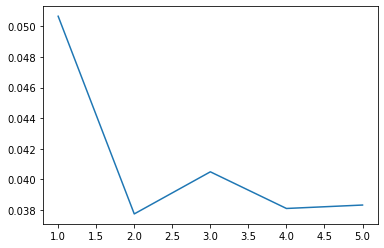

In [62]:
#Plot the losses
plt.plot(epx, test_losses)
plt.show()

In [18]:
#Test the model
RNN_model.eval()
test_loss = 0.

for batch_idx, (contexts, targets) in enumerate(test_loader):
            
    #send information to device
    contexts, targets = contexts.to(device), targets.to(device)

    #run the forward pass
    preds = RNN_model(contexts.float())

    #compute loss
    loss = F.mse_loss(preds, targets.float())
    test_loss += loss.item()

test_loss /= len(valid_loader)
print(f"Test Loss: {test_loss:.6f}")

Test Loss: 0.026563


### Task 1 Part 2: GRU and LSTM

In [19]:
#Initialize the Models
GRU_model = Model("GRU", in_dim, hidden_dim, out_dim, num_layers, batch_size)
LSTM_model = Model("LSTM", in_dim, hidden_dim, out_dim, num_layers, batch_size)
GRU_optimizer = optim.Adam(GRU_model.parameters(), lr=learning_rate)
LSTM_optimizer = optim.Adam(LSTM_model.parameters(), lr=learning_rate)

#send the model to the device
GRU_model = GRU_model.to(device)
LSTM_model = LSTM_model.to(device)
GRU_model.train()
LSTM_model.train()

Model(
  (r): LSTM(1, 4, num_layers=4, batch_first=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=40, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=1, bias=True)
)

In [20]:
#Train both models
gru_losses = []
epx = []
for epoch in range(1, epochs+1):
    sum_loss = 0.
    GRU_model.train()
    for batch_idx, (contexts, targets) in enumerate(train_loader):
        
        GRU_optimizer.zero_grad()
        
        #send information to device
        contexts, targets = contexts.to(device), targets.to(device)
        
        #run the forward pass
        preds = GRU_model(contexts.float())
        
        #compute loss
        loss = F.mse_loss(preds, targets.float())
        sum_loss += loss.item()
        
        #backpropagate
        loss.backward()
        GRU_optimizer.step()
    
    sum_loss /= len(train_loader)
    GRU_model.eval()
    
    with torch.no_grad():
        valid_loss = 0.
        for batch_idx, (contexts, targets) in enumerate(valid_loader):
            
            #send information to device
            contexts, targets = contexts.to(device), targets.to(device)
            
            #run the forward pass
            preds = GRU_model(contexts.float())
            
            #compute loss
            loss = F.mse_loss(preds, targets.float())
            valid_loss += loss.item()
        
        valid_loss /= len(valid_loader)
    
    print(f"Epoch: {epoch}, Test Loss: {sum_loss:.6f}, Validation Loss: {valid_loss:.6f}")
    
    #graphing stats
    gru_losses.append(sum_loss)
    epx.append(epoch)

Epoch: 1, Test Loss: 0.053413, Validation Loss: 0.036165
Epoch: 2, Test Loss: 0.036645, Validation Loss: 0.036106
Epoch: 3, Test Loss: 0.036715, Validation Loss: 0.036240
Epoch: 4, Test Loss: 0.036745, Validation Loss: 0.036074
Epoch: 5, Test Loss: 0.036709, Validation Loss: 0.036809


In [21]:
#Train both models
lstm_losses = []
epx = []
for epoch in range(1, epochs+1):
    sum_loss = 0.
    GRU_model.train()
    for batch_idx, (contexts, targets) in enumerate(train_loader):
        
        LSTM_optimizer.zero_grad()
        
        #send information to device
        contexts, targets = contexts.to(device), targets.to(device)
        
        #run the forward pass
        preds = LSTM_model(contexts.float())
        
        #compute loss
        loss = F.mse_loss(preds, targets.float())
        sum_loss += loss.item()
        
        #backpropagate
        loss.backward()
        LSTM_optimizer.step()
    
    sum_loss /= len(train_loader)
    LSTM_model.eval()
    
    with torch.no_grad():
        valid_loss = 0.
        for batch_idx, (contexts, targets) in enumerate(valid_loader):
            
            #send information to device
            contexts, targets = contexts.to(device), targets.to(device)
            
            #run the forward pass
            preds = LSTM_model(contexts.float())
            
            #compute loss
            loss = F.mse_loss(preds, targets.float())
            valid_loss += loss.item()
        
        valid_loss /= len(valid_loader)
    
    print(f"Epoch: {epoch}, Test Loss: {sum_loss:.6f}, Validation Loss: {valid_loss:.6f}")
    
    #graphing stats
    lstm_losses.append(sum_loss)
    epx.append(epoch)

Epoch: 1, Test Loss: 0.041371, Validation Loss: 0.036438
Epoch: 2, Test Loss: 0.037362, Validation Loss: 0.040863
Epoch: 3, Test Loss: 0.036932, Validation Loss: 0.036081
Epoch: 4, Test Loss: 0.037174, Validation Loss: 0.036014
Epoch: 5, Test Loss: 0.036923, Validation Loss: 0.036436


Plot the Losses

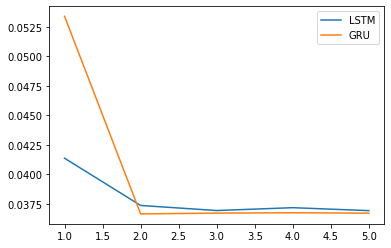

In [23]:
plt.plot(epx, lstm_losses, label = "LSTM")
plt.plot(epx, gru_losses, label = "GRU")
plt.legend()
plt.show()

Test the Two Models

In [24]:
#Test the model
GRU_model.eval()
LSTM_model.eval()
GRU_loss = 0.
LSTM_loss = 0.

for batch_idx, (contexts, targets) in enumerate(test_loader):
            
    #send information to device
    contexts, targets = contexts.to(device), targets.to(device)

    #run the forward pass
    GRU_preds = GRU_model(contexts.float())
    LSTM_preds = LSTM_model(contexts.float())

    #compute loss
    g_loss = F.mse_loss(GRU_preds, targets.float())
    l_loss = F.mse_loss(LSTM_preds, targets.float())
    
    GRU_loss += g_loss.item()
    LSTM_loss += l_loss.item()

GRU_loss /= len(valid_loader)
LSTM_loss /= len(valid_loader)
print(f"GRU Test Loss: {GRU_loss:.6f}, LSTM Test Loss: {LSTM_loss:.6f}")

GRU Test Loss: 0.024245, LSTM Test Loss: 0.024268


We see that LSTM and GRU performs the best with LSTM performing slightly better on the test set while RNN performs the worst. This is likely due to the fact that LSTM and GRU both contain gates that help it regulate information throughout the training process and therefore are better capable of learning time related data while it is harder for RNN to do this as it cannot forget data. Additionally, LSTMS also provide the bonus of preventing vanishing gradients.

### Task 1 Part 3: FFN to solve the same problem.

Generally, using a feed forwards network to solve a time series problem is not a great idea as feed forward networks do not take into account the temporal aspect of data, meaning the order of the data does not matter. Since order is a defining feature of time series data, this make it hard for feed forward networks to generalize on time series data. An approach we may use to mitigate this problem would be to use positional encoding to encode the order of the data in a way such that the feed forward network can take account and make use of.

### Task 2: Word2vec and Cosine Similarity

The embeddings used in this task will be Stanford's GloVe embeddings. For this set of embeddings, we will use cosine similarity as a similarity metric and euclidean distance as the dissimilarity metric. Euclidean distance serves as a good dissimilarity metric because it calculates the distance between two embeddings so we know that if the distance is high, the two words are not similar.

In [25]:
embeddings = {}
with open("../../PIML/HW4/glove.6B.100d.txt") as f:
    lines = f.readlines()
    for line in lines:
        vals = line.split(' ')
        word = vals[0]
        embeds = [float(vals[i]) for i in range(1, len(vals)-1)]
        embeddings[word] = embeds

In [58]:
def evaluate(embeddings, word1, word2):
    """
    Evaluates the cosine similarity and euclidean distance
    for the pair word1, word2.
    """
    e1 = embeddings[word1]
    e2 = embeddings[word2]
    
    #calculate cosine similarity
    c_sim = np.dot(e1, e2)
    
    e_sum, e2_sum = 0, 0
    for e in e1: e_sum += e**2
    for e in e2: e2_sum += e**2
    
    t_sum = math.sqrt(e_sum) * math.sqrt(e2_sum)
    c_sim /= t_sum
        
     
    #calculate euclidean distance
    e_d = 0
    for idx, (d1, d2) in enumerate(zip(e1, e2)):
        e_d += (d2 - d1)**2
    e_d = math.sqrt(e_d)
    
    print(f"Cosine Similarity: {c_sim}, Euclidean Distance: {e_d}")
    
    return c_sim, e_d

In [59]:
evaluate(embeddings, "tree", "rock")

Cosine Similarity: 0.40571518545469115, Euclidean Distance: 6.7061982600888035


(0.40571518545469115, 6.7061982600888035)